In [1]:
 import os
import glob
import datetime
import tarfile
import urllib.request

def download_dataset(filename, url, work_dir):
    if not os.path.exists(filename):
        print("[INFO] Downloading flowers17 dataset....")
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
        print("[INFO] Succesfully downloaded " + filename + " " + str(statinfo.st_size) + " bytes.")
        untar(filename, work_dir)


In [2]:
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

def untar(fname, path):
    tar = tarfile.open(fname)
    tar.extractall(path=path, members=jpg_files(tar))
    tar.close()
    print("[INFO] Dataset extracted successfully.")

In [5]:
if __name__ == '__main__':
    flowers17_url  = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"
    flowers17_name = "17flowers.tgz"
    train_dir      = "dataset"

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)

    download_dataset(flowers17_name, flowers17_url, train_dir)
    if os.path.exists(train_dir + "\\jpg"):
        os.rename(train_dir + "\\jpg", train_dir + "\\train2")


	# get the class label limit
    class_limit = 17

    # take all the images from the dataset
    image_paths = glob.glob(train_dir + "\\train2\\*.jpg")
    print(image_paths)

    # variables to keep track
    label = 0
    i = 0
    j = 80

    # flower17 class names
    class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
                   "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
                   "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
                   "windflower", "pansy"]

	# loop over the class labels
    for x in range(1, class_limit+1):
        # create a folder for that class
        os.makedirs(train_dir + "\\train2\\" + class_names[label])
        
        # get the current path
        cur_path = train_dir + "\\train2\\" + class_names[label] + "\\"
        
		# loop over the images in the dataset
        for index, image_path in enumerate(image_paths[i:j], start=1):
            original_path   = image_path
            image_path      = image_path.split("\\")
            image_file_name = str(index) + ".jpg"
            os.rename(original_path, cur_path + image_file_name)
		
        i += 80
        j += 80
        label += 1


[]


In [6]:
print(train_dir)

dataset


In [12]:
import sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "dataset/train2/"
h5_data          = 'output/data.h5'
h5_labels        = 'output/labels.h5'
bins             = 8



In [13]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
#d_hu_moments(image)

In [14]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick
#fd_haralick(image)

In [15]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
#fd_histogram(image)

In [16]:
train_labels = os.listdir(train_path)
train_labels

['bluebell',
 'buttercup',
 'coltsfoot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lilyvalley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

In [19]:
train_labels.sort()
print(train_labels)

['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


In [20]:
# empty lists to hold feature vectors and labels
global_features = []
labels          = []

# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


[STATUS] processed folder: bluebell
[STATUS] processed folder: buttercup
[STATUS] processed folder: coltsfoot
[STATUS] processed folder: cowslip
[STATUS] processed folder: crocus
[STATUS] processed folder: daffodil
[STATUS] processed folder: daisy
[STATUS] processed folder: dandelion
[STATUS] processed folder: fritillary
[STATUS] processed folder: iris
[STATUS] processed folder: lilyvalley
[STATUS] processed folder: pansy
[STATUS] processed folder: snowdrop
[STATUS] processed folder: sunflower
[STATUS] processed folder: tigerlily
[STATUS] processed folder: tulip
[STATUS] processed folder: windflower
[STATUS] completed Global Feature Extraction...


In [21]:
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1360, 532)


In [22]:
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] training Labels (1360,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 16 16 16]
[STATUS] target labels shape: (1360,)
[STATUS] end of training..


In [23]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [24]:
warnings.filterwarnings('ignore')


In [26]:
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train2"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)


In [27]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))


In [28]:
# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...


In [29]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


In [30]:
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.499280 (0.057501)
LDA: 0.456764 (0.041680)
KNN: 0.352939 (0.031636)
CART: 0.468972 (0.019043)
RF: 0.642083 (0.034902)
NB: 0.372564 (0.037347)
SVM: 0.043343 (0.027239)


In [31]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"algo":["LR", "LDA", "KNN", "CART", "RF", "NB", "SVM"], "sd":[0.1,0.2,0.3,0.4,0.5,0.6,0.7], "acc":[0.499280,0.456764,0.352939,0.468972,0.642083,0.372564,0.043343]})
df

,algo,sd,acc
0,LR,0.1,0.499280
1,LDA,0.2,0.456764
2,KNN,0.3,0.352939
3,CART,0.4,0.468972
4,RF,0.5,0.642083
5,NB,0.6,0.372564
6,SVM,0.7,0.043343


<Figure size 432x288 with 0 Axes>

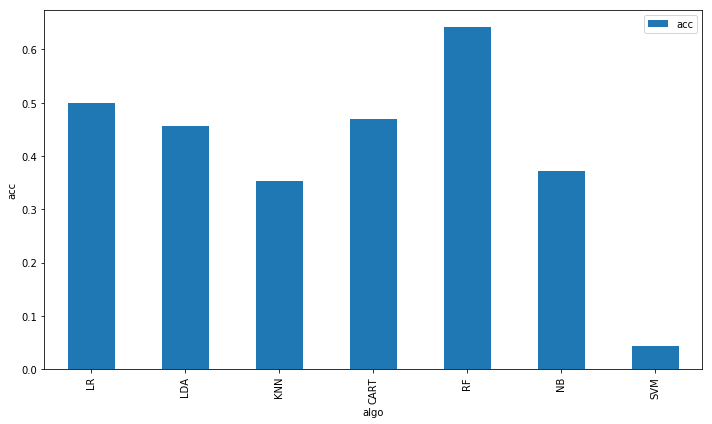

In [36]:
import matplotlib.pyplot as plt
ax = plt.figure()
ax = df.plot(kind='bar',x='algo', y='acc',figsize=[10,6])
ax.set_xlabel("algo")
ax.set_ylabel("acc")
pyplot.ylim(ymin=0)
ax = plt.tight_layout()
ax = plt.show()

def autolabel(ax):
    """
    Attach a text label above each bar displaying its height
    """
    for acc in ax:
        height = acc.get_height()
        ax.text(acc.get_x() + acc.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

#autolabel(ax)


plt.show()